In [1]:
from utils import *
from generate_data import *
from numpy.linalg import norm
from scipy.optimize import minimize

import numpy as np
import cvxpy as cp
import warnings

warnings.filterwarnings("ignore")

global k, vk_no, vk_npl

In [2]:
Ts = 0.1

N = 10
Nu = 8
Lambda = 5e-2

# 1 - population, 2 - tracking, 3 - hiv
process = 3

In [3]:
est = 'good' # good / mid / bad
y_zad, fun, x_no, u_no, x_npl, u_npl, bds, model = initialize(process, N, Nu, Ts, est)
model.print(precision=int(3 - np.log10(Ts)))

y_zad_N = np.vstack([y_zad, np.tile(y_zad[-1], (N, 1))])
kmax, vk_no, vk_npl = len(y_zad), 0, 0

(x1)[k+1] = 0.1000 1 + 0.9900 x1[k] + -0.1000 x1[k] x2[k] + 0.0980 x1[k] x2[k] u[k]
(x2)[k+1] = 0.9800 x2[k] + 0.1000 x1[k] x2[k] + -0.1000 x2[k] x4[k] + -0.1000 x2[k] x5[k] + -0.0980 x1[k] x2[k] u[k]
(x3)[k+1] = 0.9990 x3[k] + -0.0030 x2[k] x3[k] + 0.0060 x1[k] x2[k] x3[k]
(x4)[k+1] = 0.9900 x4[k] + 0.0030 x2[k] x4[k]
(x5)[k+1] = 0.9900 x5[k] + 0.0030 x2[k] x3[k]


In [4]:
def mpc_no(deltau, model=None, w=1):
    u_no[k:k+Nu] = (np.tril(np.ones((Nu, Nu)), 0) @ deltau.reshape(-1, 1) + u_no[k-1] * np.ones((Nu, 1))).reshape(-1)
    u_no[k+Nu:k+N+1] = u_no[k+Nu-1]

    if model is not None:
        for p in range(N+1):
            x_no[k+p] = model.simulate(x_no[k+p-1], t=2, u=np.array([u_no[k+p-1]]))[-1] + vk_no
    else:
        for p in range(N+1):
            x_no[k+p] = fun(t=0, state=x_no[k+p-1], T=Ts, u=u_no[k+p-1])

    return norm((y_zad_N[k]*w).reshape(-1, 1)*np.ones((1, N)) - (x_no[k+1:k+N+1]*w).T, 2) + Lambda * norm(deltau, 2)

In [5]:
def mpc_npl(model, state_est, u_prev, w=1):
    nx, nu = len(state_est), 1

    A, B = linearize(model, state_est, u_prev)

    P = np.zeros((nx*N, nu*Nu))
    xo = np.zeros((N, nx))

    for i in range(N):
        for j in range(min(i+1, Nu)):
            if i == j:
                P[nx*i:nx*(i+1), nu*j:nu*(j+1)] = B
            else:
                P[nx*i:nx*(i+1), nu*j:nu*(j+1)] = A_sum(A, i-j) @ B
        if i == 0:
            xo[i, :] = model.simulate(state_est, t=2, u=np.array([u_prev]))[-1] + vk_npl
        else:
            xo[i, :] = model.simulate(xo[i-1,:], t=2, u=np.array([u_prev]))[-1] + vk_npl

    C = np.eye(nx)
    C_bar = np.kron(np.eye(N), C)
    wx0 = (w * xo).reshape(-1, 1)
    y0 = C_bar @ wx0
    Yref = (w * y_zad_N[k] * np.ones((N, 1))).reshape(-1, 1)

    du = cp.Variable((nu*Nu, 1))
    cost = cp.sum_squares(Yref - C_bar @ P @ du - y0) + Lambda * cp.sum_squares(du)

    prob = cp.Problem(cp.Minimize(cost), constraints=[du >= -bds, du <= bds])
    prob.solve()

    return du.value[0, 0]

In [7]:
w = [0, 0, 1, 0, 0]
save = False

state_no, state_npl = x_no[0], x_npl[0]

for k in range(5, kmax):
    # -------------------- NO -----------------------
    xmod_no =  model.simulate(state_no, t=2, u=np.array([u_no[k-1]]))[-1]
    state_no = fun(t=0, state=state_no, T=Ts, u=u_no[k-1])
    x_no[k, :] = state_no

    try:
        opt = minimize(
            mpc_no,
            args=(model, w),
            x0=np.zeros(Nu),
            method='SLSQP',
            bounds=[(-bds, bds)]*Nu,
            options={'maxiter': 100, 'ftol': 1e-6}
        )
        du_no = opt.x[0]
    except np.linalg.LinAlgError as e:
        print(f"Optimization failed due to: {e}")
        du_no = 0
    
    u_no[k] = u_no[k-1] + du_no
    vk_no = state_no - xmod_no

    # -------------------- NPL -----------------------

    xmod_npl =  model.simulate(state_npl, t=2, u=np.array([u_npl[k-1]]))[-1]
    state_npl = fun(t=0, state=state_npl, T=Ts, u=u_npl[k-1])
    x_npl[k, :] = state_npl

    try:
        du_npl = mpc_npl(model, state_npl, u_npl[k-1], w)
    except Exception as e:
        print(f"NPL failed at step {k}: {e}")
        du_npl = 0

    u_npl[k] = u_npl[k-1] + du_npl
    vk_npl = state_npl - xmod_npl

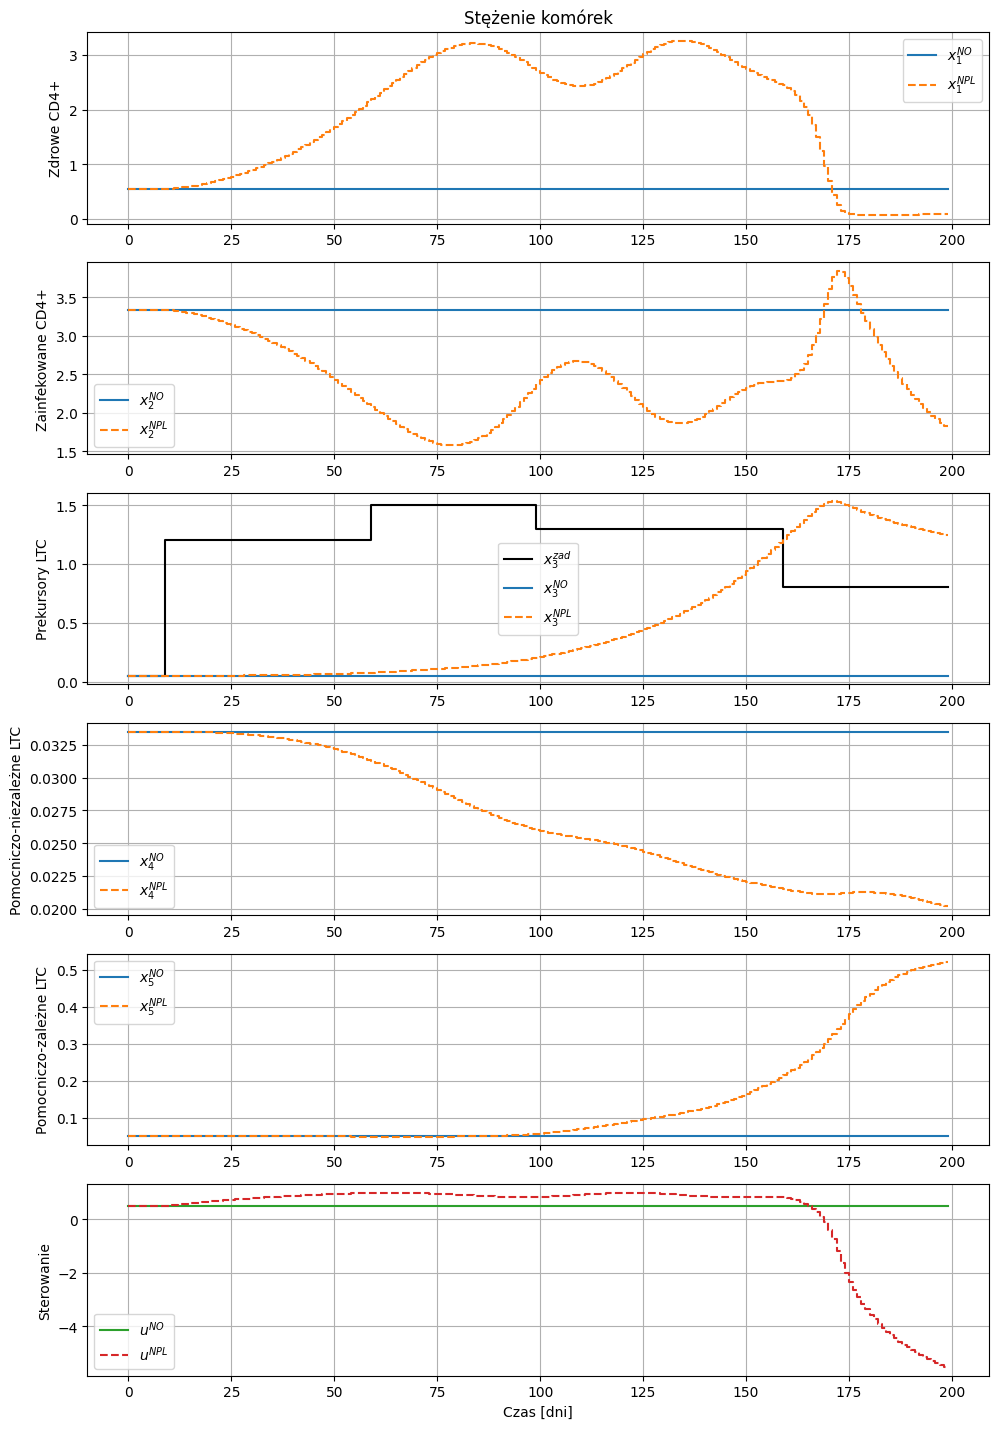

In [8]:
path = f"experiments/{process}/MPC {est} proces-{process} w={w}"
fig, axs = plt.subplots(len(x_no[0]) + 1, 1, figsize=(10, 2.4*(len(x_no[0]) + 1)))
if len(x_no[0]) == 2:
    axs[0].set_title("Liczba osobników")
    axs[0].set_ylabel("Populacja ofiar")
    axs[1].set_ylabel("Populacja drapieżników")
    axs[2].set_ylabel("Sterowanie")
    axs[-1].set_xlabel("Czas [dni]")
    process = 1
elif len(x_no[0]) == 3:
    axs[0].set_title("Parametry lotu")
    axs[0].set_ylabel("Kąt natarcia")
    axs[1].set_ylabel("Kąt nachylenia")
    axs[2].set_ylabel("Współczynnik nachylenia")
    axs[3].set_ylabel("Sterowanie")
    axs[-1].set_xlabel("Czas [s]")
    process = 2
else:
    axs[0].set_title("Stężenie komórek")
    axs[0].set_ylabel("Zdrowe CD4+")
    axs[1].set_ylabel("Zainfekowane CD4+")
    axs[2].set_ylabel("Prekursory LTC")
    axs[3].set_ylabel("Pomocniczo-niezależne LTC")
    axs[4].set_ylabel("Pomocniczo-zależne LTC")
    axs[5].set_ylabel("Sterowanie")
    axs[-1].set_xlabel("Czas [dni]")
    process = 3
kmax = len(y_zad)

for i in range(len(x_no[0])):
    if w[i] > 0:
        axs[i].step(range(kmax), y_zad[:, i], label=f"$x_{i+1}^{{zad}}$", color='k')
    axs[i].step(range(kmax), x_no[0:kmax, i], label=f"$x_{i+1}^{{NO}}$", color=f"C{0}")
    axs[i].step(range(kmax), x_npl[0:kmax, i], label=f"$x_{i+1}^{{NPL}}$", color=f"C{1}", linestyle='--')
    axs[i].legend()
    axs[i].grid()
axs[-1].step(range(kmax), u_no[0:kmax], label=f"$u^{{NO}}$", color=f"C{2}")
axs[-1].step(range(kmax), u_npl[0:kmax], label=f"$u^{{NPL}}$", color=f"C{3}", linestyle='--')
axs[-1].legend()
axs[-1].grid()
plt.tight_layout()
plt.show()

if save:
    fig.savefig(path + '.pdf', bbox_inches='tight')